# Face Mask Recognition

In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# the directory of the files
DIRECTORY = r"D:\Ritwik's Download\Deep Learning\Face Mask\data"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
data = []
labels = []

In [6]:
# in data it store the image in array format
# in label it store the label of the image(with mask/without mask)

for category in CATEGORIES:
    # join the directory with the catagory folder consist 
    # of the images
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        # store the image total path
    	img_path = os.path.join(path, img)
        
        # load the image using tensorflow.keras image processor
        # height-224, width-224
    	image = load_img(img_path, target_size=(224, 224))
        
        # convert the image to a array
    	image = img_to_array(image)
    	image = preprocess_input(image)

        # the image array to data
    	data.append(image)
    	labels.append(category)


C:\Users\RITWIK GANGULY\anaconda3\envs\Ritwik_DATA_Sci\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Model Development

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,
	           test_size=0.20, random_state=42)

In [33]:
X_train.shape

(6042, 224, 224, 3)

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 11s 1us/step


In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [18]:
import tensorflow as tf

In [36]:
# compile our model

adam = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])

In [37]:
H = model.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_train) // BS,
	epochs=10)

Epoch 1/10
188/188 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9739WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 188 batches). You may need to use the repeat() function when building your dataset.


188/188 [==============================] - 324s 2s/step - loss: 0.0923 - accuracy: 0.9739 - val_loss: 0.0493 - val_accuracy: 0.9861
Epoch 2/10
188/188 [==============================] - 262s 1s/step - loss: 0.0635 - accuracy: 0.9822
Epoch 3/10
188/188 [==============================] - 274s 1s/step - loss: 0.0537 - accuracy: 0.9847
Epoch 4/10
188/188 [==============================] - 257s 1s/step - loss: 0.0523 - accuracy: 0.9845
Epoch 5/10
188/188 [==============================] - 245s 1s/step - loss: 0.0458 - accuracy: 0.9850
Epoch 6/10
188/188 [==============================] - 236s 1s/step - loss: 0.0385 - accuracy: 0.9889
Epoch 7/10
188/188 [==============================] - 234s 1s/step - loss: 0.0405 - accuracy: 0.9867
Epoch 8/10
188/188 [==============================] - 234s 1s/step - loss: 0.0358 - accuracy: 0.9900
Epoch 9/10
188/188 [==============================] - 237s 1s/step - loss: 0.0385 - accuracy: 0.9885
Epoch 10/10
188/188 [==============================] - 238s 

In [61]:
predIdxs = model.predict(X_test, batch_size=BS)

48/48 [==============================] - 23s 479ms/step


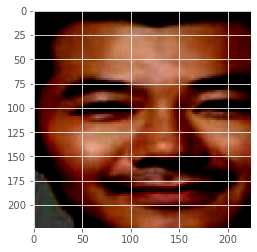

In [83]:
plt.imshow(X_train[502], cmap="gray")
plt.show()

In [84]:
lb.classes_[np.argmax(predIdxs[502])]

'without_mask'

### Epochs vs Accuracy

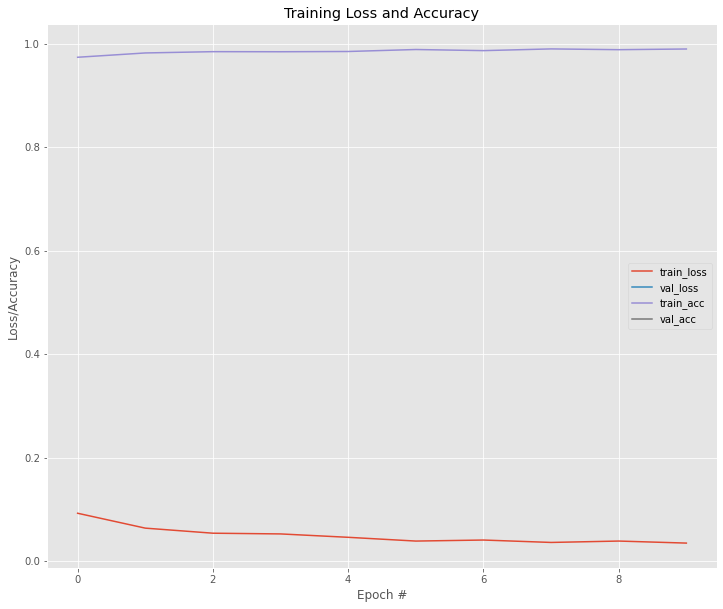

In [88]:
N = 10
plt.style.use("ggplot")
plt.figure(figsize=(12, 10))
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

## Accuracy and Classification Report

In [72]:
y_pred_classes = np.argmax(predIdxs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [74]:
print(classification_report(y_pred_classes, y_true_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       765
           1       0.99      0.99      0.99       746

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [76]:
model.evaluate(X_test, y_test)

48/48 [==============================] - 22s 463ms/step - loss: 0.0246 - accuracy: 0.9907


[0.02462942525744438, 0.9907346367835999]

> **Save the model as mask_detector_dl.model as a h5 file**

## The Model Testing Section

In [7]:
import tensorflow as tf

In [8]:
os.chdir(r"D:\Ritwik's Download\Deep Learning\Face Mask")

In [9]:
model = tf.keras.models.load_model("mask_detector_dl.model")

In [10]:
import cv2

# the test image preprocessing
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    img = img.reshape(1, 224, 224, 3)  # Reshape to (1, width, height, channels)
    return img

In [11]:
# predict the result

def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    mask_probability = prediction[0][0]
    predicted_class = np.argmax(prediction)

    if predicted_class == 0:
        result = "with_mask"
    else:
        result = "without_mask"

    return result, mask_probability

In [12]:
# show the image with prediction - 1

def show_image_with_prediction1(image_path):
    result, mask_probability = predict_image(image_path)
    img = cv2.imread(image_path)
    cv2.putText(img, f"Prediction: {result} ({mask_probability:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Face Mask Prediction", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [16]:
import IPython.display as display

# show image with prediction - 2
def show_image_with_prediction2(image_path):
    result, mask_probability = predict_image(image_path)
    img = cv2.imread(image_path)
    cv2.putText(img, f"Prediction: {result} ({mask_probability:.2f})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Convert BGR image to RGB (OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using IPython.display
    display.display(display.Image(data=cv2.imencode('.png', img_rgb)[1].tobytes()))


In [19]:
path1 = "D:\Ritwik's Download\Deep Learning\Face Mask\mask_01.jpeg"

In [21]:
predict_image(path1)

1/1 [==============================] - 0s 86ms/step


('with_mask', 0.9999995)

1/1 [==============================] - 0s 86ms/step


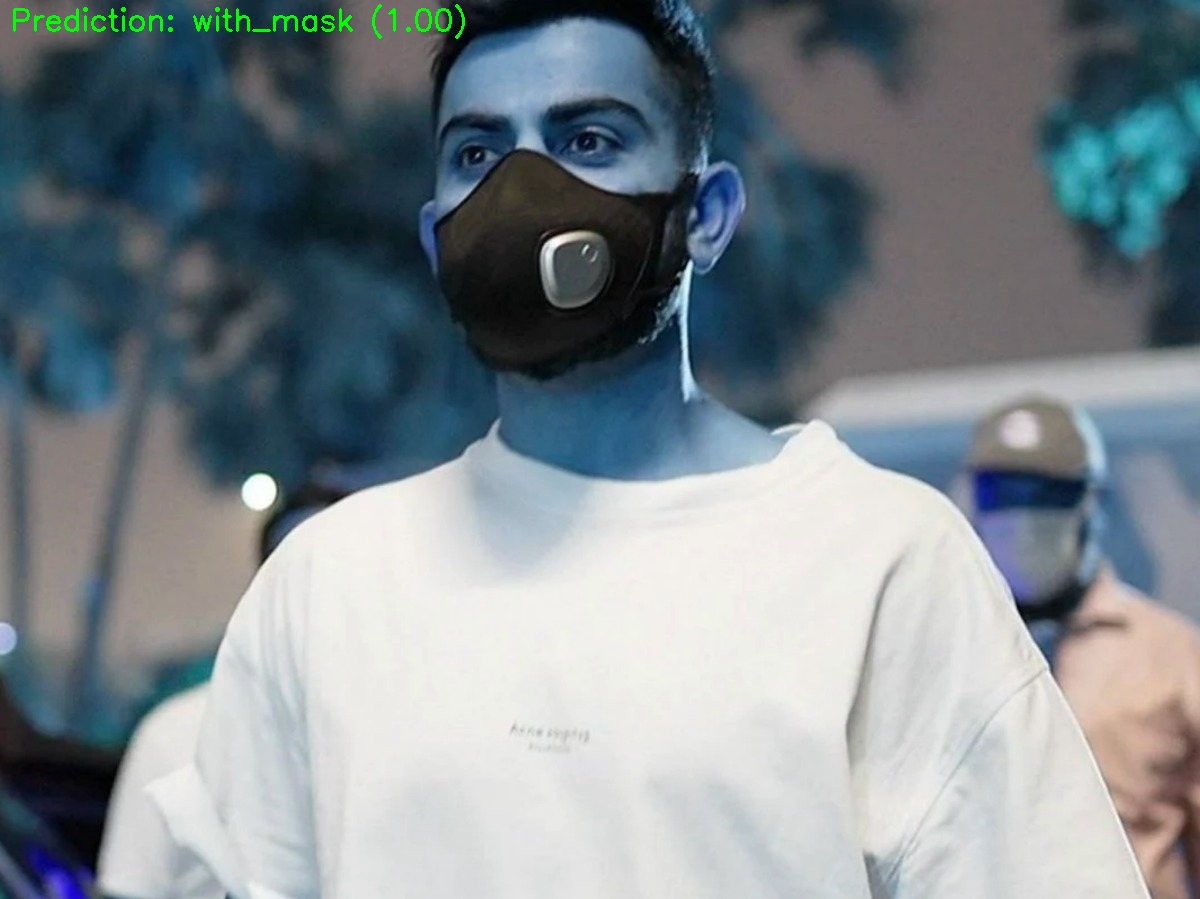

In [22]:
show_image_with_prediction2(path1)

In [27]:
path2 = "D:\Ritwik's Download\Deep Learning\Face Mask\mask_02.jpg"

In [28]:
predict_image(path2)

1/1 [==============================] - 0s 173ms/step


('without_mask', 0.024489809)

1/1 [==============================] - 0s 106ms/step


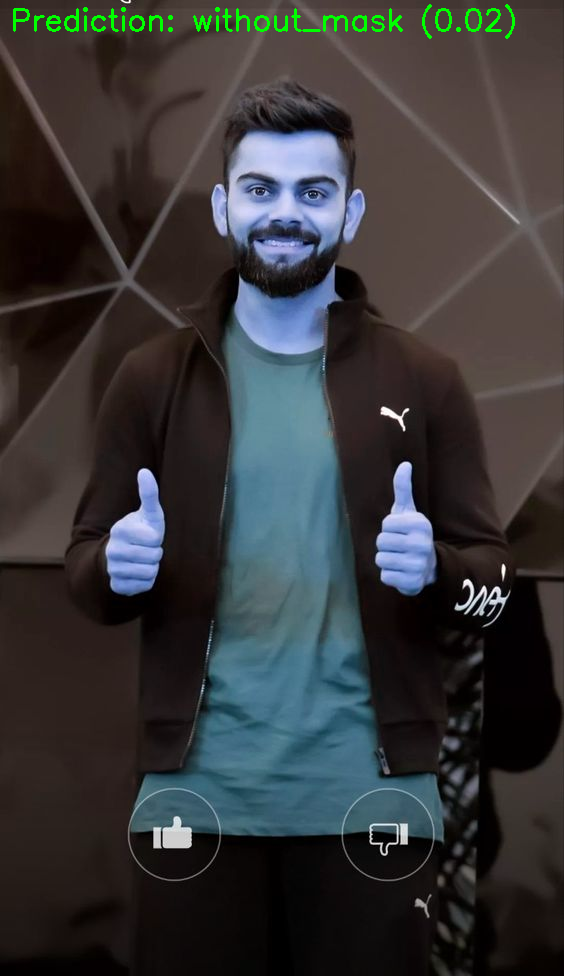

In [29]:
show_image_with_prediction2(path2)

## Face Detector

#### The OpenCV Section -- Update later

In [46]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

In [48]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))
            
            
            # only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)


# Thank You